# Imports

In [2]:
# Data Processing
import pandas as pd 
import numpy as np 
import scipy.io 

import time
import random 

# Plotting 
from matplotlib import pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib import style
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.image as mpimg 

plt.rcParams['animation.ffmpeg_path'] = "C:\\ffmpeg\\bin\\ffmpeg.exe"

import seaborn as sns

style.use('ggplot')

# Machine Learning 
import sklearn 

# Models 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 

# Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Preprocessing 
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 

# Saving models 
from sklearn.externals import joblib

C:\Users\vatsa\Miniconda3\envs\indoor_location_v2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Now to get the data and do some basic processing. 

In [3]:
emitter_mat = scipy.io.loadmat("Emitter_cir_noise.mat")
cal_cir_mat = scipy.io.loadmat("cal_cir_noise.mat")
dataset_mat = scipy.io.loadmat("dataset_cir.mat")

emitter_df = pd.DataFrame(emitter_mat['Emitter_cir_noise'])
cal_cir_df = pd.DataFrame(cal_cir_mat['cal_cir_noise'])
dataset_df = pd.DataFrame(dataset_mat['dataset_cir'])

In [4]:
X_knn_pipeline = joblib.load('Pipelines/knn_pipeline.joblib')
X_nn_pipeline = joblib.load('Pipelines/nn_pipeline.joblib')
y_lat_pipeline = joblib.load('Pipelines/y_lab_pipeline.joblib')
y_long_pipeline = joblib.load('Pipelines/y_long_pipeline.joblib')

# Confidence Ellipse Plotting 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

Take one point of the calibration dataset (label, features)

In [6]:
sample = cal_cir_df.iloc[1:2,:]
sample_x = sample.iloc[:,3:]
sample_y = sample.iloc[:,0:2]

sample_x

,3,4,5,6,7,8,9,10,11,12,...,153,154,155,156,157,158,159,160,161,162
1,1309.021847,43.452352,1309.322648,43.688232,1309.264286,43.662395,1268.757415,42.554359,1319.092893,42.486553,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054


Add noise to the features to create 1000 different noisy samples for the same point 

In [7]:
def create_noisy_sample(X):
    noise = np.zeros(X.shape)
    for idx, column in enumerate(X):
        mu, sigma = X[column].mean(), X[column].std()
        noise[:, idx] = np.random.normal(0, 0.1*sigma, [X.shape[0], 1]).ravel()

    return noise 

X_train = dataset_df.iloc[:, 3:]
noise = create_noisy_sample(X_train)

In [8]:
noise_df = pd.DataFrame(noise, columns=list(range(3, 163))).iloc[:1000]
noise_df.head()

,3,4,5,6,7,8,9,10,11,12,...,153,154,155,156,157,158,159,160,161,162
0,41.954035,0.241116,-256.884569,0.970084,-342.388592,-2.247816,-43.804284,3.891669,-332.331222,1.347417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,111.712674,-1.247853,-142.616193,-1.570322,452.318497,0.863762,-31.549947,-1.706557,-333.454300,-1.711561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.024466,0.218958,107.012677,-3.371980,-5.877359,-1.584877,-278.605742,-3.010781,-101.280286,-0.688517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.327929,2.627159,-199.282453,-0.201204,144.343797,-0.819831,0.620453,-1.129766,-136.227561,-0.910944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56.591278,0.978091,109.347794,-3.828890,-235.779604,4.051311,-97.616202,-0.302337,-172.487759,0.362851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
sample_x_repl = sample_x.append([sample_x.iloc[0, :]]*999, ignore_index=True)
sample_y_repl = sample_y.append([sample_y.iloc[0, :]]*999, ignore_index=True)

sample_y_repl.head()

,0,1
0,636998.0,5616300.0
1,636998.0,5616300.0
2,636998.0,5616300.0
3,636998.0,5616300.0
4,636998.0,5616300.0


In [10]:
noisy_sample_df = sample_x_repl + noise_df
noisy_sample_df.head()

,3,4,5,6,7,8,9,10,11,12,...,153,154,155,156,157,158,159,160,161,162
0,1350.975882,43.693468,1052.438079,44.658316,966.875693,41.414579,1224.953132,46.446028,986.761672,43.833970,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054
1,1420.734521,42.204499,1166.706454,42.117910,1761.582783,44.526158,1237.207469,40.847802,985.638593,40.774992,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054
2,1312.046313,43.671310,1416.335325,40.316252,1303.386926,42.077518,990.151673,39.543579,1217.812607,41.798036,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054
3,1342.349776,46.079511,1110.040194,43.487028,1453.608083,42.842565,1269.377868,41.424593,1182.865332,41.575609,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054
4,1365.613125,44.430443,1418.670442,39.859342,1073.484682,47.713706,1171.141214,42.252022,1146.605134,42.849403,...,-0.097572,0.014457,0.050612,0.151787,0.233115,-0.302818,0.134828,0.059919,0.007081,0.099054


We now have 1000 noisy samples for a single point. 

In [11]:
# Convert sample features and labels to array to pass into random forest algorithm 
noisy_samples = np.array(noisy_sample_df)
y_samples = np.array(sample_y_repl)

In [12]:
y_samples_lat = y_lat_pipeline.transform(y_samples[:, 0].reshape(-1, 1))
y_samples_long = y_long_pipeline.transform(y_samples[:, 1].reshape(-1, 1))
y_samples = np.concatenate((y_samples_lat, y_samples_long), axis=1)

In [14]:
def error_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
 
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    lat_rmse = np.sqrt(mean_squared_error(y_test_lat, y_pred_lat))
    long_rmse = np.sqrt(mean_squared_error(y_test_long, y_pred_long))
    error_dist = np.sqrt(lat_rmse**2 + long_rmse**2)

    return lat_rmse, long_rmse, error_dist

def plot_2D_predictions(model, range_beg, range_end, X_test, y_test):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    y_pred = model.predict(X_test)
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    
    y_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.xlim(int(y_lat.min()) - 150, int(y_lat.max()) + 150)
    plt.ylim(int(y_long.min()) - 150, int(y_long.max()) + 150)

    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    ax.plot([y_pred_lat.squeeze(),y_test_lat.squeeze()], 
             [y_pred_long.squeeze(),y_test_long.squeeze()], color='red', marker='.')

    ax.plot(y_pred_lat[range_beg:range_end], y_pred_long[range_beg:range_end], 'g.')
    ax.plot(y_test_lat[range_beg:range_end], y_test_long[range_beg:range_end], 'b.')
    plt.show()
    
    return np.concatenate([y_pred_lat, y_pred_long], axis=1)

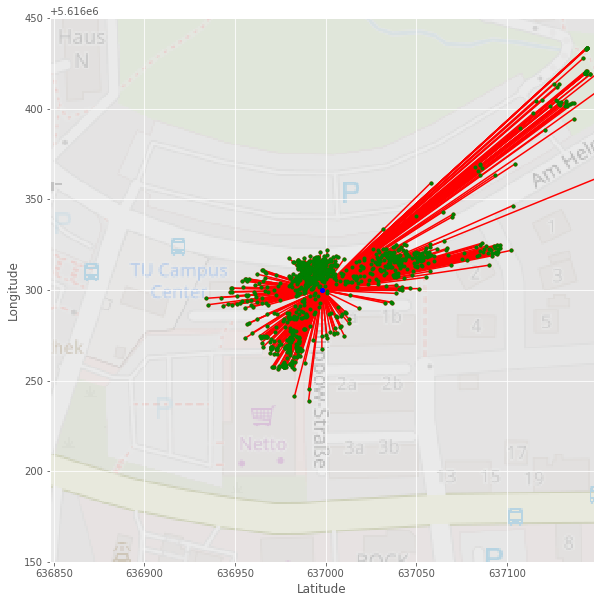

In [15]:
rf_reg = joblib.load('Regression Models/rf_vanilla.sav')
lat_rmse, long_rmse, error_dist = error_metrics(rf_reg, noisy_samples, y_samples)
y_preds = plot_2D_predictions(model=rf_reg, X_test=noisy_samples, y_test=y_samples, range_beg=1, range_end=1000)

Remove outliers using interquartile range. (Q1 - 1.5IQR, Q3 + 1.5IQR) 

In [16]:
y_preds_df = pd.DataFrame(y_preds)

def iqr_outlier(y_preds_df):
    lat_q1 = y_preds_df[0].quantile(0.25)
    lat_q3 = y_preds_df[0].quantile(0.75)
    lat_IQR = lat_q3 - lat_q1

    long_q1 = y_preds_df[1].quantile(0.25)
    long_q3 = y_preds_df[1].quantile(0.75)
    long_IQR = long_q3 - long_q1

    is_outlier = ((y_preds_df[0] < lat_q1 - 1.5 * lat_IQR) | 
                 (y_preds_df[0] > lat_q3 + 1.5 * lat_IQR) |
                 (y_preds_df[1] < long_q1 - 1.5 * long_IQR) | 
                 (y_preds_df[1] > long_q3 + 1.5 * long_IQR))
    
    clean_y_preds_df = y_preds_df[~is_outlier]
    outliers_df = y_preds_df[is_outlier]

    print(clean_y_preds_df.shape)
    clean_y_preds = np.array(clean_y_preds_df)    
    outliers = np.array(outliers_df)
    return clean_y_preds, outliers  

def zscore_outlier(y_preds_df):
    lat_mean = y_preds_df[0].mean()
    lat_std = y_preds_df[0].std()

    long_mean = y_preds_df[1].mean()
    long_std = y_preds_df[1].std()

    lat_cutoff = 2 * lat_std
    long_cutoff = 2 * long_std 
    
    lat_bounds = [lat_mean - lat_cutoff, lat_mean + lat_cutoff]
    long_bounds = [long_mean - long_cutoff, long_mean + long_cutoff]
    
    is_outlier = ((y_preds_df[0] < lat_bounds[0]) | 
                 (y_preds_df[0] > lat_bounds[1]) |
                 (y_preds_df[1] < long_bounds[0]) |
                 (y_preds_df[1] > long_bounds[1]))
    
    clean_y_preds_df = y_preds_df[~is_outlier]
    
    outliers_df = y_preds_df[is_outlier]
    
    print(clean_y_preds_df.shape)
    print(lat_mean, long_mean)
    clean_y_preds = np.array(clean_y_preds_df)
    outliers = np.array(outliers_df)
    return clean_y_preds, outliers  


iqr_clean_y_preds, iqr_outliers = iqr_outlier(y_preds_df)
z_clean_y_preds, z_outliers = zscore_outlier(y_preds_df)

(937, 2)
(942, 2)
637010.3499074099 5616306.138018134


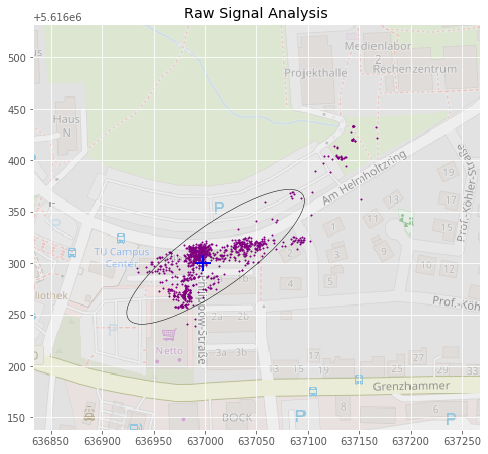

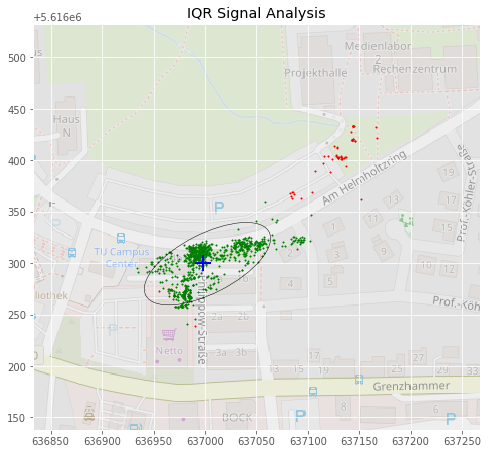

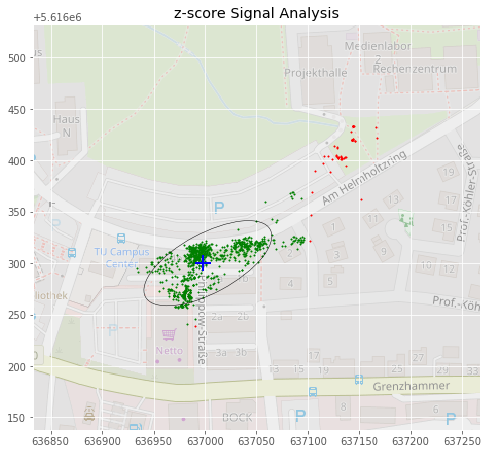

In [17]:
# Code: https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

raw_x, raw_y = y_preds[:, 0], y_preds[:, 1]

iqr_xc, iqr_yc = iqr_clean_y_preds[:, 0], iqr_clean_y_preds[:, 1]
iqr_xo, iqr_yo = iqr_outliers[:, 0], iqr_outliers[:, 1]

z_xc, z_yc = z_clean_y_preds[:, 0], z_clean_y_preds[:, 1]
z_xo, z_yo = z_outliers[:, 0], z_outliers[:, 1]

nstd = 2

def create_confidence_ellipse(x, y, xo, yo, title, color='green'):
    fig, ax = plt.subplots(figsize=(8, 8))
    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

    plt.xlim(int(raw_x.min()) - 100, int(raw_x.max()) + 100)
    plt.ylim(int(raw_y.min()) - 100, int(raw_y.max()) + 100)

    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    plt.scatter(x, y, s=2, c=color)
    plt.scatter(xo, yo, s=2, c='red')

    y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
    y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))

    plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
    plt.title(title)
    plt.show()

    
create_confidence_ellipse(raw_x, raw_y, np.array([]), np.array([]), 'Raw Signal Analysis', color='purple')    
create_confidence_ellipse(iqr_xc, iqr_yc, iqr_xo, iqr_yo, 'IQR Signal Analysis')
create_confidence_ellipse(z_xc, z_yc, z_xo, z_yo, 'z-score Signal Analysis')

In [18]:
print(y_preds_df[0].min(), y_preds_df[0].max(), y_preds_df[0].max() - y_preds_df[0].min())
print(y_preds_df[1].min(), y_preds_df[1].max(), y_preds_df[1].max() - y_preds_df[1].min())

636933.7327528003 637167.1618257095 233.42907290917356
5616238.884752631 5616433.61833564 194.73358300887048


In [20]:
# Sources: 
# http://chris35wills.github.io/courses/PythonPackages_matplotlib/matplotlib_3d/

from scipy import misc 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib._png import read_png
import matplotlib.image as mpimg 

In [23]:
data_array = np.load('Outputs/dem.npy')
print(data_array)
ny, nx = data_array.shape
print(ny, nx)

[[567. 573. 577. ... 497. 491. 488.]
 [567. 572. 577. ... 491. 488. 486.]
 [563. 566. 569. ... 493. 491. 489.]
 ...
 [672. 665. 655. ... 509. 500. 485.]
 [670. 662. 654. ... 493. 487. 482.]
 [660. 649. 639. ... 486. 481. 478.]]
49 89


In [24]:
# Create the x and y bounds 
x = np.arange(0, nx)
y = np.arange(0, ny)
x,y

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]))

In [25]:
# Coordinate starting points 
start_y = 5616275
start_x = 636975

end_y = start_y + ny 
end_x = start_x + nx

x, y = np.mgrid[start_y:end_y, start_x:end_x]

# Crop coordinate arrays to dimension of elevation data

def crop_data(y_preds):
    z_xlist = []
    z_ylist = []
    z_zlist = []

    for i in range(y_preds.shape[0]):
        x, y = int(y_preds[i, 0]), int(y_preds[i, 1])
        if (x-start_x > 0) & (end_x-x > 0) & (y-start_y > 0) & (end_y-y > 0):
            z_xlist.append(x)
            z_ylist.append(y)
            
    z_x, z_y = np.array(z_xlist).astype(int), np.array(z_ylist).astype(int)
    
    for i in range(len(z_xlist)):
        z_zlist.append(data_array[(z_y - start_y)[i], (z_x - start_x)[i]])

    z_z = np.array(z_zlist)
    return z_x, z_y, z_z

z_xc, z_yc, z_zc = crop_data(z_clean_y_preds)
z_xo, z_yo, z_zo = crop_data(z_outliers)

# Check the shapes of the data and the outliers 
print(z_xc.shape == z_yc.shape == z_zc.shape, z_xc.shape)
print(z_xo.shape == z_yo.shape == z_zo.shape, z_xo.shape) # This is empty 

True (622,)
True (0,)


(49, 89, 4)


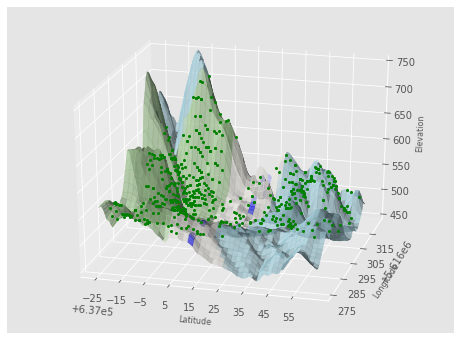

In [26]:
# Create the surface plot using x,y,z 
fig = plt.figure(figsize=(8, 6))

img = mpimg.imread('base.png')

# Custom section of image extracted 
img_start_y = 132
img_start_x = 22

img = img[img_start_y:img_start_y+ny, img_start_x:img_start_x+nx, :]
print(img.shape)

ax = plt.axes(projection='3d')
plt.yticks(np.arange(start_y, end_y, 10))
plt.xticks(np.arange(start_x, end_x, 10))

ax.set_xlabel('Latitude', fontsize=8)
ax.set_ylabel('Longitude', fontsize=8)
ax.set_zlabel('Elevation', fontsize=8)

ax.plot_surface(y, x, data_array, facecolors=img, 
                linewidth=0.5, antialiased=True, alpha=0.7)
ax.plot(z_xc, z_yc, z_zc, 'go', markersize=2)
ax.view_init(elev=25., azim=45*6+15)

plt.show()

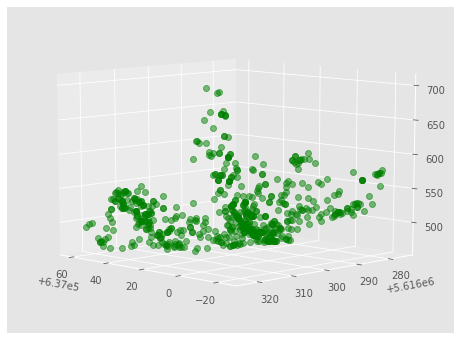

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot(z_xc, z_yc, z_zc, 'go', alpha=0.5)
ax.view_init(elev=10., azim=135)
plt.show()